In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas as pd

%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.metrics import mean_squared_error

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

In [ ]:
from datetime import datetime

In [ ]:
symbol = 'SRMBNB'

In [ ]:
!pip install python-binance
!pip install tpot

from binance.client import Client

import json
with open('creds.json') as f:
  data = json.load(f)

client = Client(data['key'],data['secret'])

In [ ]:
candles = client.get_klines(symbol=symbol,interval=Client.KLINE_INTERVAL_1MINUTE)

In [ ]:
len(candles)

In [ ]:
candles[499]

In [ ]:
price = np.array([float(candles[i][4]) for i in range(500)])

In [ ]:
time = np.array([int(candles[i][0]) for i in range(500)])

t = np.array([datetime.fromtimestamp(time[i]/1000).strftime('%H:%M:%S') for i in range(500)])

In [ ]:
price.shape

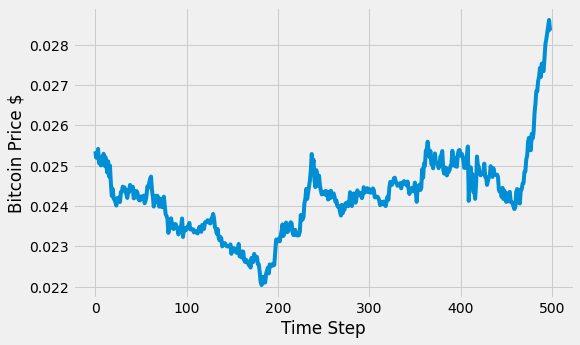

In [ ]:
plt.figure(figsize=(8,5))
plt.xlabel('Time Step')
plt.ylabel('Bitcoin Price $')
plt.plot(price)

In [ ]:
timeframe = pd.DataFrame({'Time':t,'Price $BTC':price})

timeframe #minute by minute price

,Time,Price $BTC
0,02:24:00,0.025358
1,02:25:00,0.025200
2,02:26:00,0.025303
3,02:27:00,0.025418
4,02:28:00,0.025066
...,...,...
495,10:39:00,0.028299
496,10:40:00,0.028472
497,10:41:00,0.028613
498,10:42:00,0.028361


In [ ]:
price = price.reshape(500,1)

In [ ]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

In [ ]:
scaler.fit(price[:374])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
price = scaler.transform(price)

In [ ]:
df = pd.DataFrame(price.reshape(100,5), columns = ['First', 'Second', 'Third', 'Fourth', 'Target'])

In [ ]:
df.head()

,First,Second,Third,Fourth,Target
0,1.929224,1.717641,1.855572,2.009572,1.538198
1,1.725676,1.461868,1.717641,1.502041,1.847537
2,1.449815,1.737728,1.461868,1.224842,1.597120
3,1.093607,1.453833,0.873990,0.449486,0.679816
4,0.357086,0.324947,0.236564,0.129434,0.378512


In [ ]:
#75% train, 25% test 

x_train = df.iloc[:74, :4]
y_train = df.iloc[:74, -1]

x_test = df.iloc[75:99, :4]
y_test = df.iloc[75:99, -1]

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
x_train.shape, x_test.shape

((74, 4, 1), (24, 4, 1))

In [ ]:
model = Sequential()

model.add(LSTM(20, return_sequences=True, input_shape=(4, 1)))
model.add(LSTM(40, return_sequences=False))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mse', optimizer = 'rmsprop')

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 4, 20)             1760      
_________________________________________________________________
lstm_13 (LSTM)               (None, 40)                9760      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
Total params: 11,561
Trainable params: 11,561
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, batch_size=5, epochs = 100)

Epoch 1/100
15/15 [==============================] - 3s 5ms/step - loss: 0.9057
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4431
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: 0.1567
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0636
Epoch 5/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0538
Epoch 6/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0689
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0701
Epoch 8/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0638
Epoch 9/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0676
Epoch 10/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0843
Epoch 11/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0659
Epoch 12/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0789
Epoch 13/100
15/15 [=================

In [ ]:
y_pred = model.predict(x_test)

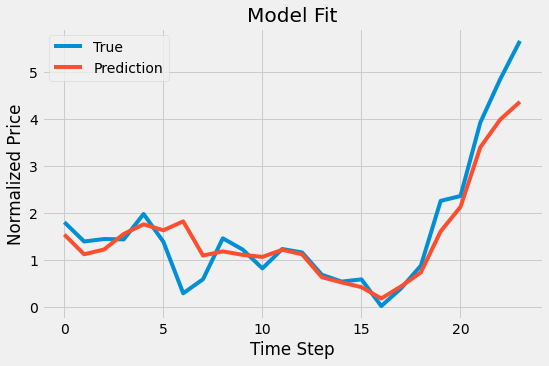

In [ ]:
plt.figure(figsize=[8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Prediction')
plt.legend()

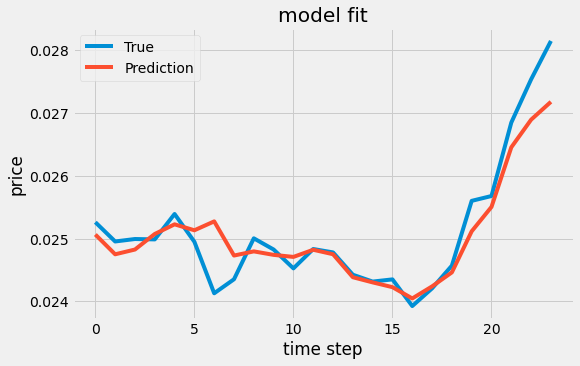

In [ ]:
plt.figure(figsize=[8,5])
plt.title('model fit')
plt.xlabel('time step')
plt.ylabel('price')
plt.plot(scaler.inverse_transform(y_test), label='True')
plt.plot(scaler.inverse_transform(y_pred), label='Prediction')
plt.legend()

In [ ]:
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred)))
print('Test score: %.2f RMSE' % (testScore))

Test score: 0.00 RMSE


In [ ]:
from sklearn.metrics import r2_score

In [ ]:
print('RSsquared :', '{:.2%}'.format(r2_score(y_test, y_pred)))

RSsquared : 86.00%


In [ ]:
model.save("Bitcoin_model.h5")

In [ ]:
#from keras.models import load_model

# load model
#model = load_model('Bitcoin_model.h5')

# summarize model
#model.summary()

# **Second Model**

In [ ]:
from sklearn.svm import SVR

In [ ]:
#75% train, 25% test 

trainX = df.iloc[:74, :4]
trainY = df.iloc[:74, -1]

testX = df.iloc[75:99, :4]
testY = df.iloc[75:99, -1]

In [ ]:
svr_linear = SVR(kernel = 'linear', C=1e3, gamma = 0.1)
svr_linear.fit(trainX, trainY)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
predY = svr_linear.predict(testX)

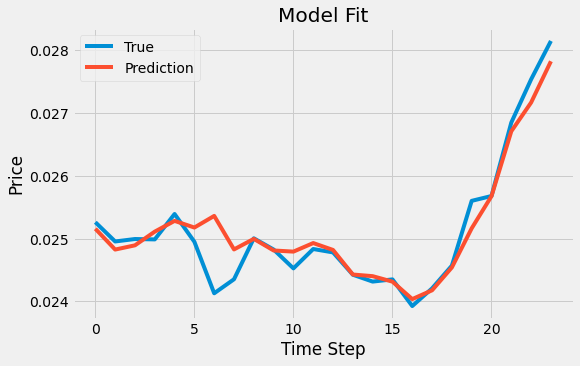

In [ ]:
plt.figure(figsize=[8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.plot(scaler.inverse_transform(testY), label='True')
plt.plot(scaler.inverse_transform(predY), label='Prediction')
plt.legend()

In [ ]:
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(testY), scaler.inverse_transform(predY)))
print('Test score: %.2f RMSE' % (testScore))

Test score: 0.00 RMSE


In [ ]:
print('RSsquared : ',  '{:.2%}'.format(r2_score(testY, predY)))

RSsquared :  90.42%


# **Hyperparameter Tuning**

In [ ]:
param_grid = {"C": [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4 ],
			  "gamma": np.logspace (-2, 2, 50),
			  'epsilon':[0.1,0.2,0.5,0.3]}

from sklearn.model_selection import RandomizedSearchCV

In [ ]:
svm_model = SVR(kernel='linear')

In [ ]:
grid_search = RandomizedSearchCV(svm_model, param_grid, scoring = 'r2', n_jobs=-1 )

grid_search.fit(trainX, trainY)

print(grid_search.best_estimator_)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.20235896477251566, kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
svm_model = SVR(C=10000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=100.0, kernel = 'linear', max_iter = -1, shrinking=True, tol = 0.001, verbose=False)

svm_model.fit(trainX, trainY)

pred = svm_model.predict(testX)

In [ ]:
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(testY), scaler.inverse_transform(pred)))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.00 RMSE


In [ ]:
print('RSsquared :', '{:.2%}'.format(r2_score(testY,pred)))

RSsquared : 90.36%


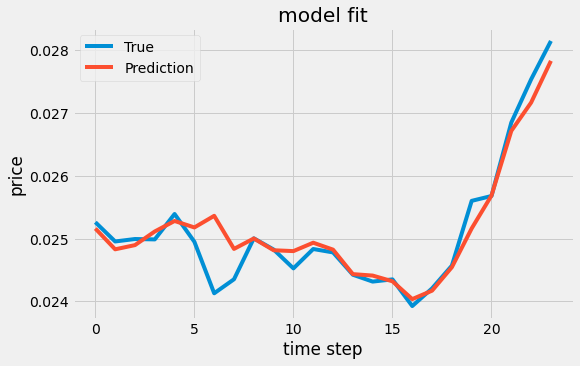

In [ ]:
plt.figure(figsize=[8,5])
plt.title('model fit')
plt.xlabel('time step')
plt.ylabel('price')
plt.plot(scaler.inverse_transform(testY), label='True')
plt.plot(scaler.inverse_transform(pred), label='Prediction')
plt.legend()

# **Ridge Regression**

In [ ]:
from sklearn.linear_model import RidgeCV

In [ ]:
ridge = RidgeCV()

In [ ]:
ridge.fit(trainX, trainY)

Rpred = ridge.predict(testX)

In [ ]:
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(testY), scaler.inverse_transform(Rpred)))
print('Test Score: ', testScore)

Test Score:  0.00031314915317529664


In [ ]:
print('RSquared: ', '{:.2%}'.format(r2_score(testY, Rpred)))

RSquared:  90.64%


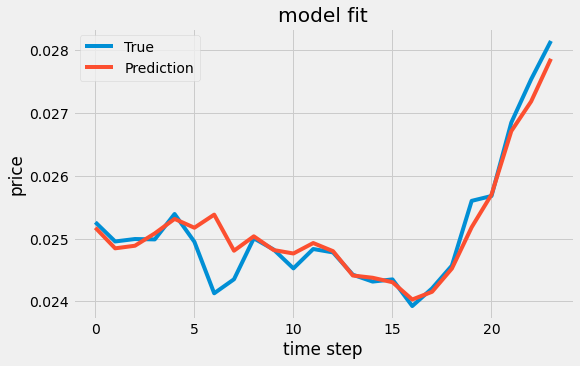

In [ ]:
plt.figure(figsize=[8,5])
plt.title('model fit')
plt.xlabel('time step')
plt.ylabel('price')
plt.plot(scaler.inverse_transform(testY), label='True')
plt.plot(scaler.inverse_transform(Rpred), label='Prediction')
plt.legend()

# **Hyperparameter Tuning**

In [ ]:
normal_price = np.array([float(candles[i][4]) for i in range(500)])

In [ ]:
data = pd.DataFrame(normal_price.reshape(100,5), columns = ['first', 'second', 'third', 'fourth', 'target' ])

In [ ]:
data.head()

,first,second,third,fourth,target
0,0.025358,0.025200,0.025303,0.025418,0.025066
1,0.025206,0.025009,0.025200,0.025039,0.025297
2,0.025000,0.025215,0.025009,0.024832,0.025110
3,0.024734,0.025003,0.024570,0.024253,0.024425
4,0.024184,0.024160,0.024094,0.024014,0.024200


In [ ]:
data.tail()

,first,second,third,fourth,target
95,0.025694,0.025410,0.025384,0.025791,0.025677
96,0.025822,0.026281,0.026532,0.026845,0.026845
97,0.027100,0.027200,0.027425,0.027200,0.027532
98,0.027362,0.027345,0.027686,0.028021,0.028143
99,0.028299,0.028472,0.028613,0.028361,0.028342


In [ ]:
#75% train, 25% test

x_train_r = df.iloc[:74, :4]
y_train_r = df.iloc[:74, -1]

x_test_r = df.iloc[75:99, :4]
y_test_r = df.iloc[75:99, -1]

In [ ]:
from tpot import TPOTRegressor

tpot = TPOTRegressor(generations = 5, population_size =50, verbosity = 2)
tpot.fit(x_train_r, y_train_r)


Generation 1 - Current best internal CV score: -0.03824220975812463

Generation 2 - Current best internal CV score: -0.03824220975812463

Generation 3 - Current best internal CV score: -0.03816542640286657

Generation 4 - Current best internal CV score: -0.03816542640286657

Generation 5 - Current best internal CV score: -0.03816542640286657

Best pipeline: LassoLarsCV(ZeroCount(LassoLarsCV(input_matrix, normalize=False)), normalize=False)


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
              disable_update_check=False, early_stop=None, generations=5,
              log_file=None, max_eval_time_mins=5, max_time_mins=None,
              memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=50,
              random_state=None, scoring=None, subsample=1.0, template=None,
              use_dask=False, verbosity=2, warm_start=False)

In [ ]:
tpred = tpot.predict(x_test_r)

In [ ]:
testScore = np.sqrt(mean_squared_error(y_test_r, tpred))
print('Test Score: %.2f RMSE' % (testScore))

print('RSquared :','{:.2%}'.format(r2_score(y_test_r,tpred)))

Test Score: 0.42 RMSE
RSquared : 90.56%


In [ ]:
tpot.export('bitcoin.py')

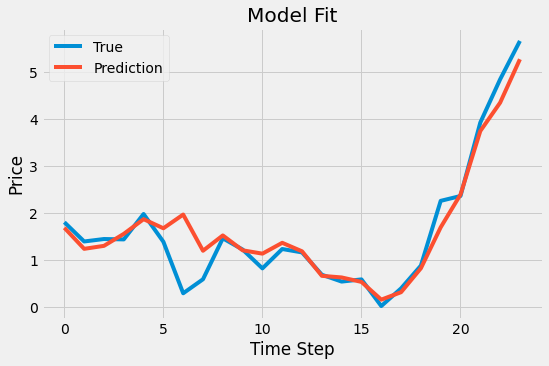

In [ ]:
plt.figure(figsize=[8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.plot(np.array(y_test_r).reshape(24,),label='True')
plt.plot(tpred,label='Prediction')
plt.legend()

# **Trading Bot**

In [ ]:
check = client.get_klines(symbol=symbol,interval=Client.KLINE_INTERVAL_1MINUTE)

check[499]

[1614077100000,
 '0.02902000',
 '0.02911800',
 '0.02882500',
 '0.02897400',
 '3017.00000000',
 1614077159999,
 '87.30615800',
 46,
 '1487.00000000',
 '43.11741100',
 '0']

In [ ]:
index = [496,495,498,499]

candles = scaler.transform(np.array([float(check[i][4]) for i in index]).reshape(1,-1))

model_feed = candles.reshape(1,4,1)

scaler.inverse_transform(model.predict(model_feed)[0])[0]

0.027627386

In [ ]:
# trading bot

quantity = '0.05' # quantity to trade

order = False

index = [496,495,498,499]

# Sample Stuff
account = 500
risk = 0.05
asset = 0
last_account = 0
start_account = account

while True:
  price = client.get_recent_trades(symbol=symbol)
  candle = client.get_klines(symbol=symbol,interval=client.KLINE_INTERVAL_1MINUTE)
  candles = scaler.transform(np.array([float(candle[i][4]) for i in index]).reshape(1,-1))
  model_feed = candles.reshape(1,4,1)
  
  if order == False and float(price[len(price)-1]['price']) < float(scaler.inverse_transform(model.predict(model_feed)[0])[0]):
    #client.order_market_buy(symbol=symbol,quantity=quantity)
    order = True
    buy_price = client.get_order_book(symbol=symbol)['asks'][0][0]
    print('Buy @Market Price :',float(buy_price),' Timestamp :',str(datetime.now()))

    last_account = account
    asset = (account*risk)/float(buy_price)

    # Binance Fee of 0.1%
    asset = asset-asset*0.001

    account -= account*risk
  elif order == True and float(price[len(price)-1]['price'])-float(buy_price) >= 10:
    #client.order_market_sell(symbol=symbol,quantity=quantity)
    order = False
    sell_price = client.get_order_book(symbol=symbol)['bids'][0][0]

    print('Sell @Market Price :',float(sell_price),' Timestamp :',str(datetime.now()))

    # Binance Fee of 0.1%
    sold_for = asset*float(sell_price)
    sold_for = sold_for-sold_for*0.001

    account += sold_for
    asset = 0

    # if account > last_account:
    #   print('Trade Change: +',(1-last_account/account)*100,'%')
    # else:
    #   print('Trade Change: -',(1-account/last_account)*100,'%')

    # print('Overall Change: $',account-start_account)
    # print('Account Size: ',account)

    last_account = 0
  else:
    pass

0.001686573455691339
0.001686573455691339
0.001856573455691339
0.001841290452241899
0.001841290452241899
0.001841290452241899
0.0016747934882640828
0.0016747934882640828
0.0016747934882640828
0.0016747934882640828
0.0016747934882640828
0.0019943820809125885
0.0019943820809125885
0.0019943820809125885
0.0016713820809125916
0.0016713820809125916
0.0016870618277788178
0.0016870618277788178
0.0016870618277788178
0.0016870618277788178
0.0016870618277788178
0.0016870618277788178
0.0016870618277788178
0.0016870618277788178
0.0016870618277788178
0.0016870618277788178
0.0017600618277788145
0.0017600618277788145
0.0017600618277788145
0.0017534997289180738
0.0017534997289180738
0.0017534997289180738
0.0017534997289180738
0.0017534997289180738
0.0017534997289180738
0.0017534997289180738
0.0017534997289180738
0.0017534997289180738
0.0017534997289180738
0.0017534997289180738
0.0017534997289180738
0.0017534997289180738
0.0017534997289180738
0.001819499728918074
0.001819499728918074
0.0018137534686326

KeyboardInterrupt: ignored